In [1]:
from typing import Annotated, List, Dict, Any
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI

In [2]:
class MemState(TypedDict):
    messages: Annotated[List, add_messages]
    session_id: str

In [3]:
class MemoryStore:
    def __init__(self):
        self.__db: Dict[str, List] = {}
    def get(self, session_id: str) -> List:
        return list(self.__db.get(session_id, []))
    def set(self, session_id: str, msgs: List) -> List:
        self.__db[self.__db_key(session_id) if hasattr(self, '__db_key') else session_id] = list(msgs)
    def clear(self, session_id: str) -> None:
        self.__db.pop(session_id, None)

In [4]:
MEMORY = MemoryStore()

In [5]:
def _rough_token_count(messages: List) -> int:
    total = 0
    for m in messages:
        text = getattr(m, "content", "")
        total += len(str(text).split())
    return total

In [6]:
def trim_to_budget(messages: List, max_tokens: int=200) -> List:
    kept = []
    running = 0
    for m in reversed(messages):
        words = len(str(getattr(m, "content", "")).split())
        if running + words > max_tokens:
            break
        kept.append(m)
        running += words
    return list(reversed(kept))

In [7]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [8]:
def route(state: MemState) -> str:
    last = state['messages'][-1].content.lower()
    if any(w in last for w in ["reset", "clear memory", "clear", "start over"]):
        return "clear"
    return "chat"

In [9]:
def chat_node(state: MemState) -> Dict[str, Any]:
    session = state['session_id']
    past = MEMORY.get(session)
    current = state['messages']
    prompt_messages = past+current

    ai = llm.invoke(prompt_messages)
    return {'messages': [ai]}

In [10]:
def clear_memory_node(state: MemState) -> Dict[str, Any]:
    session = state['session_id']
    MEMORY.clear(session)
    return {'messages': [AIMessage(content="Memory cleared for this session")]}

In [11]:
def save_and_trim_node(state: MemState) -> Dict[str, Any]:
    session = state['session_id']
    past = MEMORY.get(session)
    new_turn = state['messages'][-2:]
    combined = past+new_turn
    trimmed = trim_to_budget(combined, max_tokens=200)
    MEMORY.set(session, trimmed)

    return {}

In [12]:
graph = StateGraph(MemState)
graph.add_node("chat", chat_node)
graph.add_node("clear", clear_memory_node)
graph.add_node("save", save_and_trim_node)

graph.add_conditional_edges(
    START,
    route,
    {"chat": "chat", "clear": "clear"}
)
graph.add_edge("chat", "save")
graph.add_edge("clear", END)
graph.add_edge("save", END)

app = graph.compile()

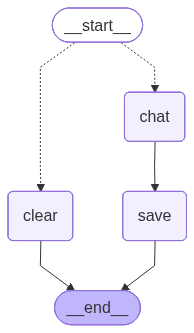

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [25]:
def test(user_input, session):
    state: MemState = {
        "session_id": session,
        "messages": [HumanMessage(content=user_input)],
    }
    state = app.invoke(state)
    print("\n--- Response 1 ---")
    for m in state["messages"]:
        print(m.__class__.__name__, ":", m.content)

In [26]:
test("Hi My name is Manmath", "demo-001")


--- Response 1 ---
HumanMessage : Hi My name is Manmath
AIMessage : Hi Manmath! It's nice to meet you. How can I assist you today?


In [27]:
test("What is my name?", "demo-001")


--- Response 1 ---
HumanMessage : What is my name?
AIMessage : Your name is Manmath! How can I help you today, Manmath?


In [28]:
test("Please clear all memory", "demo-001")


--- Response 1 ---
HumanMessage : Please clear all memory
AIMessage : Memory cleared for this session


In [29]:
test("What is my name?", "demo-001")


--- Response 1 ---
HumanMessage : What is my name?
AIMessage : I don't have access to personal data about users unless it has been shared with me in the course of our conversation. Therefore, I don't know your name. If you'd like to share it or if there's something else you'd like to discuss, feel free to let me know!
